In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn.metrics.pairwise import rbf_kernel

In [7]:
num_data = 800
num_samples = num_data // 2
num_features = 2
num_centers = 4
rand_seed = 100

In [3]:
np.random.seed(rand_seed)
data = np.random.rand(num_data, num_features)

In [3]:
import scipy.io
mat = scipy.io.loadmat('Syndata.mat')
data = mat['data']
data.shape

(800, 2)

In [59]:
# K = rbf_kernel(data, data, 1.8)
# print(f"K: {K.shape}")
# np.dot(K[k, :], K[:, k]) / (K[k, k] + lambda_)

In [4]:
# make some fake data X and y
np.random.seed(0)
train_X = np.random.rand(100, 3)
train_y = np.random.randint(0,10, size=100)
# print(train_y.min(), train_y.max())
svc = SVC()
svc.fit(train_X, train_y)

SVC()

In [5]:
test_X = np.random.rand(1, 3)
svc.predict(test_X)

array([2])

In [62]:
# def rbf_kernel(X, Y, sigma):
#     N, K = X.shape
#     M = Y.shape[0]

#     K_xy = np.ones(M)*np.sum(X**2) + np.ones(N)*np.sum(Y**2) - 2*np.dot(X, Y.transpose())
#     K_xy = np.exp(-0.5 * K_xy / sigma**2)

#     return K_xy

In [4]:
# data = np.array(([1,1],[1,2],[3,3]))
K = rbf_kernel(data, data, 0.5/1.8**2)
print(f"K: {K.shape}")
print(K[:10])
# print(K.all(0))

K: (800, 800)
[[1.         0.59074884 0.13457268 ... 0.57338521 0.45933699 0.55391671]
 [0.59074884 1.         0.44798158 ... 0.30198901 0.32430225 0.3045359 ]
 [0.13457268 0.44798158 1.         ... 0.0205365  0.02175677 0.02047644]
 ...
 [0.04446417 0.15316068 0.76746522 ... 0.00315454 0.0029463  0.00306847]
 [0.52420108 0.97270888 0.58496747 ... 0.21117854 0.22340615 0.21209356]
 [0.09093962 0.1754758  0.6411057  ... 0.0065074  0.00512237 0.0061704 ]]


In [5]:
def halving(K, m, candidate_index=None, lambda_=0.001):
    
    n = K.shape[0]
    # print(f'number of data: {n}')

    m = min(n, m)
    # print(f'number of samples: {m}')

    if candidate_index is None:
        candidate_index = np.array(range(n))
    
    # print(f'candidate_index: {candidate_index}')

    q = len(candidate_index)

    index = np.empty(m, dtype=int)
    # print(f'number of index: {index.shape}')

    print('Selecting samples......')
    for i in range(m):
        score = np.zeros(q)
        for j in range(q):
            if candidate_index[j] == -1:
                continue
            else:
                k = candidate_index[j]
                # print(k)
                score[j] = np.dot(K[k, :], K[:, k]) / (K[k, k] + lambda_)
        
        I = score.argmax()
        # print(I)
        index[i] = candidate_index[I]

        candidate_index[I] = -1
        
        # update K
        # K = K - np.dot(K[:, index[i]], K[index[i], :]) / (K[index[i], index[i]] + lambda_)
        K = K - K[:, index[i]][:, np.newaxis] @ K[index[i], :][np.newaxis, :] / (K[index[i], index[i]] + lambda_)

    print('Done.\n')
    return index

In [8]:
# K_random = np.random.rand(100, 100)
# print(K_random[:10])
id = halving(K, num_samples)
# print(id)
print(len(set(id)))

Selecting samples......
Done.

400


In [5]:
def number_density(data, center, radius):
    # print(f'length of data: {len(data)}\nlength of center: {len(center)}')
    f = 0
    for i in range(len(data)):
        ball_dist = np.zeros(len(center))
        dist = np.ones(len(center))
        for j in range(len(center)):
            dist[j] = np.linalg.norm(data[i, :] - center[j, :])
            if dist[j] < radius:
                ball_dist[j] = dist[j]

        # print(np.exp(ball_dist/1.8))
        f += np.sum(np.exp(ball_dist/1.8)**2) / (len(ball_dist) + 1)
    
    return f

In [10]:
# kmeans = KMeans(n_clusters=num_centers).fit(data)
# center = kmeans.cluster_centers_
# f = number_density(data, center, radius=0.25)
# f

In [6]:
def SDAL(data, k):

    kmeans = KMeans(n_clusters=k).fit(data)
    center = kmeans.cluster_centers_

    radius = 0.25
    L, R = data.shape
    
    f = number_density(data, center, radius)
    T = 0
    while T<50:
        for j in range(k):
            ball = []
            dist = np.empty(L)
            for i in range(L):
                dist[i] = np.linalg.norm(data[i] - center[j])
                if dist[i] < radius:
                    ball.append(data[i])
            if len(ball)==0:
                center[j] = center[j]
            else:
                center[j] = np.mean(ball)

        F = number_density(data, center, radius)
        
        if (F-f)==0 or len(np.argwhere(pdist(center)<2*radius))>0:
            break
        else:
            f = F
        T+=1
        radius*=1.1
    
    tree = KDTree(data)
    _, idx = tree.query(center, k=1)
    # print(idx)
    center = data[idx].squeeze()
            
    return center

In [12]:
center = SDAL(data[id], num_centers)
center

array([[0.48932338, 0.44192127],
       [0.50070912, 0.5008895 ],
       [0.11967478, 0.11446859],
       [0.90222221, 0.83737164]])

In [4]:
from sklearn.datasets import load_iris
data_iris = load_iris()

In [5]:
data = data_iris['data']
target = data_iris['target']
target_names = data_iris['target_names']
feature_names = data_iris['feature_names']
descr = data_iris['DESCR']

In [42]:
K_iris = rbf_kernel(data, data, 0.5/1.8**2)
idx = halving(K_iris, 10)
print(idx.shape)
train_data, train_target = data[idx], target[idx]
# print(train_data[0], train_target[0])
# print(data[idx[0]], target[idx[0]])

svc.fit(train_data, train_target)
# err_rate = 1 - svc.score(data, target)
# print(f'error rate: {err_rate}')

Selecting samples......
Done.

(10,)
error rate: 0.1266666666666667


In [12]:
K_iris = rbf_kernel(data, data, 0.5/1.8**2)
svc = SVC()
num_samples = []
err_rate = []
for i in range(1, 21):
    idx = halving(K_iris, 5*i)
    train_data, train_target = data[idx], target[idx]
    svc.fit(train_data, train_target)
    num_samples.append(5*i)
    err_rate.append(1 - svc.score(data, target))

print(f'number of samples: {num_samples}\nerror rate: {err_rate}')

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

number of samples: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error rate: [0.33333333333333337, 0.1266666666666667, 0.06000000000000005, 0.07333333333333336, 0.046666666666666634, 0.06666666666666665, 0.040000000000000036, 0.046666666666666634, 0.06000000000000005, 0.040000000000000036, 0.040000000000000036, 0.020000000000000018, 0.02666666

Text(0, 0.5, 'Error rate')

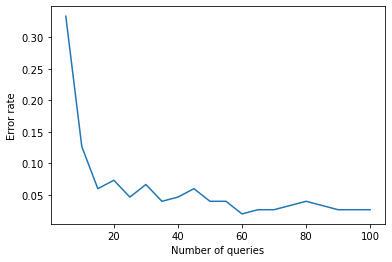

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(num_samples, err_rate)

# plt.legend(loc='lower right')
plt.xlabel('Number of queries')
plt.ylabel('Error rate')

In [1]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
 Return:
  sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])
    # 求矩阵的行数，即两个域的的样本总数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    # total1 - total2 得到的矩阵中坐标（i,j, :）代表total中第i行数据和第j行数据之间的差 
    # sum函数，对第三维进行求和，即平方后再求和，获得高斯核指数部分的分子，是L2范数的平方
    L2_distance_square = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance_square) / (n_samples**2-n_samples)
    # 多核MMD
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    print(bandwidth_list)
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance_square / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)

def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
 Return:
  loss: MMD loss
    '''
    source_num = int(source.size()[0])#一般默认为源域和目标域的batchsize相同
    target_num = int(target.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = torch.mean(kernels[:source_num, :source_num])
    YY = torch.mean(kernels[source_num:, source_num:])
    XY = torch.mean(kernels[:source_num, source_num:])
    YX = torch.mean(kernels[source_num:, :source_num])
    loss = XX + YY -XY - YX
    return loss#因为一般都是n==m，所以L矩阵一般不加入计算

In [9]:
K = rbf_kernel(data, data, gamma=0.5*1.8**(-2))

# id = halving(K,400)

indices = []
for i in range(1, 9):
    idx = halving(K, 100*i)
    indices.append(idx)

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.

Selecting samples......
Done.



In [30]:
import random
import matplotlib
import matplotlib.pyplot as plt

idx_1 = []
idx_2 = []
for i in range(8):
    idx_1.append(random.sample(list(indices[i]), 50))
    idx_2.append(random.sample(list(indices[i]), 50))

data_1 = data[idx_1, :]
data_2 = data[idx_2, :]

In [38]:
mmd_scores = []
for i in range(8):
    mmd_scores.append(mmd_rbf(torch.Tensor(data_1[i]), torch.Tensor(data_2[i])))

[tensor(6.3452), tensor(12.6904), tensor(25.3808), tensor(50.7616), tensor(101.5231)]
[tensor(6.2297), tensor(12.4593), tensor(24.9187), tensor(49.8373), tensor(99.6747)]
[tensor(6.4980), tensor(12.9959), tensor(25.9918), tensor(51.9837), tensor(103.9673)]
[tensor(5.7429), tensor(11.4859), tensor(22.9718), tensor(45.9436), tensor(91.8872)]
[tensor(5.2626), tensor(10.5251), tensor(21.0502), tensor(42.1005), tensor(84.2009)]
[tensor(6.0022), tensor(12.0043), tensor(24.0086), tensor(48.0172), tensor(96.0344)]
[tensor(5.2545), tensor(10.5091), tensor(21.0181), tensor(42.0363), tensor(84.0726)]
[tensor(6.3796), tensor(12.7592), tensor(25.5184), tensor(51.0369), tensor(102.0738)]


In [41]:
shattering_ratio = [100*i/800 for i in range (1,9)]

[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]

In [1]:
plt.plot(shattering_ratio, mmd_scores)
plt.xlabel('Shattering ratio')
plt.ylabel('MMD loss')
plt.show()

NameError: name 'plt' is not defined